# Εργασία για το Μαθημα Επεξεργασία Φυσικής Γλώσσας

In [574]:
from urllib import request
import numpy as np
import nltk
from nltk import word_tokenize, pos_tag, sent_tokenize, FreqDist, ConditionalFreqDist, RegexpParser, ne_chunk, corpus
from nltk.stem import PorterStemmer
import matplotlib.pyplot
import pandas as pd
import re
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cmakr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cmakr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\cmakr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cmakr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Naive Bayes import

In [575]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_score, accuracy_score, recall_score, classification_report, precision_recall_curve, confusion_matrix, f1_score
from sklearn.feature_extraction.text import CountVectorizer

Πηγή: https://medium.com/@shuv.sdr/na%C3%AFve-bayes-classification-in-python-f869c2e0dbf1

## Word2Vec + Classifier import

In [576]:
import gensim
from gensim.models import Word2Vec
import seaborn as sns

Πηγή: https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/

# RNN (LSTM)

In [577]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras import Input

In [578]:
# Πίνακες μετρικών για όλα τα μοντέλα (global scope)
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

In [579]:
df = pd.read_csv('mail_data.csv', encoding='utf-8')

# Φιλτραρισμα και Ελεγχος email

Μέχρι τον αλγόριθμό Naive Bayes κάνουμε κάποιους ελέγχους ως προς τα δεδομένα που διαβάζουμε

In [580]:
print(df.head())

  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...


In [581]:
ham_df = df[df['Category'] == 'ham'].copy()
spam_df = df[df['Category'] == 'spam'].copy()

In [582]:
print('Πλήθος των Email', len(ham_df))

Πλήθος των Email 4825


In [583]:
print('Πλήθος των Spam', len(spam_df))

Πλήθος των Spam 747


In [584]:
print(ham_df.head(100))

    Category                                            Message
0        ham  Go until jurong point, crazy.. Available only ...
1        ham                      Ok lar... Joking wif u oni...
3        ham  U dun say so early hor... U c already then say...
4        ham  Nah I don't think he goes to usf, he lives aro...
6        ham  Even my brother is not like to speak with me. ...
..       ...                                                ...
112      ham                    Going for dinner.msg you after.
113      ham  I'm ok wif it cos i like 2 try new things. But...
115      ham  Wa, ur openin sentence very formal... Anyway, ...
116      ham  As I entered my cabin my PA said, '' Happy B'd...
118      ham  Goodo! Yes we must speak friday - egg-potato r...

[100 rows x 2 columns]


In [585]:
ham_messages = ham_df['Message']

In [586]:
print(ham_messages.head(100))

0      Go until jurong point, crazy.. Available only ...
1                          Ok lar... Joking wif u oni...
3      U dun say so early hor... U c already then say...
4      Nah I don't think he goes to usf, he lives aro...
6      Even my brother is not like to speak with me. ...
                             ...                        
112                      Going for dinner.msg you after.
113    I'm ok wif it cos i like 2 try new things. But...
115    Wa, ur openin sentence very formal... Anyway, ...
116    As I entered my cabin my PA said, '' Happy B'd...
118    Goodo! Yes we must speak friday - egg-potato r...
Name: Message, Length: 100, dtype: object


In [587]:
total_urls = 0
total_emojis = 0
total_emoticons = 0

def clean_message(text):
    global total_urls, total_emojis, total_emoticons

    # Patterns
    url_pattern = r"http[s]?://\S+|www\.\S+"
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags=re.UNICODE)
    emoticon_pattern = r"[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]"

    # Μέτρηση URLs
    found_urls = re.findall(url_pattern, text)
    total_urls += len(found_urls)

    # Μέτρηση emojis
    found_emojis = emoji_pattern.findall(text)
    total_emojis += len(found_emojis)

    # Μέτρηση emoticons
    found_emoticons = re.findall(emoticon_pattern, text)
    total_emoticons += len(found_emoticons)

    # Καθαρισμός
    text = re.sub(url_pattern, '', text)
    text = emoji_pattern.sub('', text)
    text = re.sub(emoticon_pattern, '', text)
    text = re.sub(r'\s+', ' ', text)

    # Lowercase
    text = text.lower()

    return text.strip()

In [588]:
cleaned = ham_messages.apply(clean_message)

In [589]:
print("Βρέθηκαν " + str(total_urls) + " url")

Βρέθηκαν 2 url


In [590]:
print("Βρέθηκαν " + str(total_emojis) + " emojis")

Βρέθηκαν 2 emojis


In [591]:
print("Βρέθηκαν " + str(total_emoticons) + " emoticons")

Βρέθηκαν 471 emoticons


In [592]:
print(ham_messages.head(100))

0      Go until jurong point, crazy.. Available only ...
1                          Ok lar... Joking wif u oni...
3      U dun say so early hor... U c already then say...
4      Nah I don't think he goes to usf, he lives aro...
6      Even my brother is not like to speak with me. ...
                             ...                        
112                      Going for dinner.msg you after.
113    I'm ok wif it cos i like 2 try new things. But...
115    Wa, ur openin sentence very formal... Anyway, ...
116    As I entered my cabin my PA said, '' Happy B'd...
118    Goodo! Yes we must speak friday - egg-potato r...
Name: Message, Length: 100, dtype: object


In [593]:
ham_messages_text = ' '.join(ham_messages.astype(str))

In [594]:
ham_normalized = ham_messages_text.lower()

In [595]:
tokensHam = word_tokenize(ham_normalized)

In [596]:
tokensSentHam = sent_tokenize(ham_normalized)

In [597]:
print('Πλήθος tokens messages ΠΡΙΝ το tokenization', len(ham_normalized))

Πλήθος tokens messages ΠΡΙΝ το tokenization 349562


In [598]:
print('Πλήθος tokens messages ΜΕΤΑ το tokenization', len(tokensHam))

Πλήθος tokens messages ΜΕΤΑ το tokenization 83924


In [599]:
print('Πλήθος sentence messages ΜΕΤΑ το sent_tokenize', len(tokensSentHam))

Πλήθος sentence messages ΜΕΤΑ το sent_tokenize 5771


Παίρνει τη λίστα των αγγλικών stopwords από το NLTK και βάζει μόνο αυτές στο tokenize και αφαιρούνται σημεία στίξεις 
και λέξεις με όχι τόσο μεγάλη σημασία

In [600]:
stop_words = set(corpus.stopwords.words('english'))

In [601]:
tokensHam = [word for word in tokensHam if word.isalpha() and word not in stop_words]

Εφαρμόζουμε τον αλγόρυθμο porter για το stemming

In [602]:
stemmer = PorterStemmer()

Ομαλοποιήσουμε τις λέξεις, ώστε διαφορετικές μορφές (π.χ. run, running, runs) να αντιμετωπίζονται ως ίδιες λέξεις

In [603]:
tokensHam = [stemmer.stem(word) for word in tokensHam]

In [604]:
tokensHamPT = pos_tag(tokensHam)

In [605]:
print(tokensHamPT[:150])

[('go', 'VB'), ('jurong', 'JJ'), ('point', 'NN'), ('crazi', 'NN'), ('avail', 'NN'), ('bugi', 'NN'), ('n', 'RB'), ('great', 'JJ'), ('world', 'NN'), ('la', 'NN'), ('e', 'VBP'), ('buffet', 'JJ'), ('cine', 'NN'), ('got', 'VBD'), ('amor', 'JJ'), ('wat', 'NN'), ('ok', 'IN'), ('lar', 'JJ'), ('joke', 'NN'), ('wif', 'NN'), ('u', 'JJ'), ('oni', 'NN'), ('u', 'JJ'), ('dun', 'NNS'), ('say', 'VBP'), ('earli', 'JJ'), ('hor', 'NN'), ('u', 'JJ'), ('c', 'JJ'), ('alreadi', 'NNS'), ('say', 'VBP'), ('nah', 'JJ'), ('think', 'VBP'), ('goe', 'JJ'), ('usf', 'JJ'), ('live', 'VBP'), ('around', 'IN'), ('though', 'IN'), ('even', 'RB'), ('brother', 'JJR'), ('like', 'IN'), ('speak', 'JJ'), ('treat', 'NN'), ('like', 'IN'), ('aid', 'NN'), ('patent', 'NN'), ('per', 'IN'), ('request', 'NN'), ('mell', 'NN'), ('oru', 'IN'), ('minnaminungint', 'NN'), ('nurungu', 'NNS'), ('vettam', 'VBP'), ('set', 'VBN'), ('callertun', 'JJ'), ('caller', 'NN'), ('press', 'NN'), ('copi', 'NN'), ('friend', 'VBP'), ('callertun', 'NN'), ('gon', 

Καθαρισμός για όλα τα email σε νέα def με όλα τα πιο πάνω

In [609]:
def clean_message_all_func(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphabetic tokens
    ## tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Stem
    ## tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

In [610]:
cleanedAllMessage = df['Message'].astype(str).apply(clean_message)

In [611]:
print(cleanedAllMessage[:150])

0      go until jurong point, crazy.. available only ...
1                          ok lar... joking wif u oni...
2      free entry in 2 a wkly comp to win fa cup fina...
3      u dun say so early hor... u c already then say...
4      nah i don't think he goes to usf, he lives aro...
                             ...                        
145                            yes see ya not on the dot
146     whats the staff name who is taking class for us?
147    freemsg why haven't you replied to my text? i'...
148    ummma.will call after check in.our life will b...
149                    k..i deleted my contact that why?
Name: Message, Length: 150, dtype: object


In [612]:
cleanAllMessageFunc = cleanedAllMessage.astype(str).apply(clean_message_all_func)

In [613]:
print(cleanAllMessageFunc[:150])

0      go until jurong point , crazy .. available onl...
1                        ok lar ... joking wif u oni ...
2      free entry in 2 a wkly comp to win fa cup fina...
3      u dun say so early hor ... u c already then sa...
4      nah i do n't think he goes to usf , he lives a...
                             ...                        
145                            yes see ya not on the dot
146    whats the staff name who is taking class for us ?
147    freemsg why have n't you replied to my text ? ...
148    ummma.will call after check in.our life will b...
149                 k .. i deleted my contact that why ?
Name: Message, Length: 150, dtype: object


## Naive Bayes Αλγόρυθμός

Μετατροπή σε αριθμητικά χαρακτηριστικά

In [614]:
vec = CountVectorizer()

Χαρακτηριστικά

In [615]:
X = vec.fit_transform(cleanAllMessageFunc)

Ετικέτες

In [616]:
y = df['Category']

### Εκπαίδευση - Test split

X	Τα χαρακτηριστικά (π.χ. λέξεις) των δεδομένων

y	Οι αντίστοιχες ετικέτες (π.χ. ham, spam)

train_test_split	Συνάρτηση της scikit-learn

test_size=0.25	Το 25% των δεδομένων θα πάει στο test set

X_train	75% των χαρακτηριστικών για εκπαίδευση

X_test	25% των χαρακτηριστικών για δοκιμή

y_train	Ετικέτες για X_train

y_test	Ετικέτες για X_test

Το random_state θα το κάνουμε 42 ώστε στην επαναληψιμότητα αποτελεσμάτων να είναι πάντα ό ίδιος διαχωρσισμός 

και θα προσθέσουμε και το stratify να είναι ίσο με y για να διατηρήσει τις ίδιες αναλογίες κατηγοριών (π.χ. spam/ham)

Αν το y έχει 80% ham και 20% spam τότε και το y_train, y_test θα έχουν τι ίδια αναλογία

In [617]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify=y)

In [618]:
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [619]:
# Prediction
y_pred = classifier.predict(X_test)
y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

# Συνένωση των προβλέψεων με τις πραγματικές τιμές
result = np.concatenate((
    y_pred_array.reshape(len(y_pred_array), 1),
    y_test_array.reshape(len(y_test_array), 1)
), axis=1)
print(result)

[['ham' 'ham']
 ['ham' 'spam']
 ['ham' 'ham']
 ...
 ['spam' 'spam']
 ['ham' 'ham']
 ['ham' 'ham']]


Accuracy: Ποσοστό των σωστών προβλέψεων συνολικά

In [620]:
accuracy = accuracy_score(y_test, y_pred)

In [621]:
print(f"Accuracy : {accuracy:.4f}")

Accuracy : 0.9792


Το 96% των προβλέψεων ήταν σωστές συνολικά

Precision: Από τα "spam" που είπε ο αλγόριθμος, πόσα ήταν σωστά

In [622]:
precision = precision_score(y_test, y_pred, pos_label='spam')

In [623]:
print(f"Precision : {precision:.4f}")

Precision : 0.9202


Από τα μηνύματα που προβλέφθηκαν ως spam, το 85% ήταν όντως spam

F1 Score	Μέσος όρος Precision και Recall (harmonic mean)

In [624]:
f1_spam = f1_score(y_test, y_pred, pos_label='spam')

In [625]:
print(f"F1 Score spam : {f1_spam}")

F1 Score spam : 0.9226666666666666


Recall	Από τα πραγματικά spam, πόσα αναγνώρισε το μοντέλο

In [626]:
recall = recall_score(y_test, y_pred, pos_label='spam')

In [627]:
print(f"Recall    : {recall:.4f}")

Recall    : 0.9251


Από τα πραγματικά spam, εντοπίστηκε το 89%

In [628]:
# Προσθήκη αποτελεσματων για το Naive Βαυεσ
accuracy_scores["Naive Bayes"] = accuracy
precision_scores["Naive Bayes"] = precision
recall_scores["Naive Bayes"] = recall
f1_scores["Naive Bayes"] = f1_spam

<Axes: >

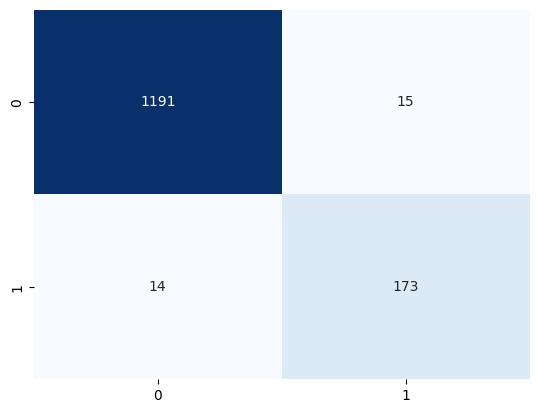

In [629]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

Πάνω αριστερά: σωστά ham

Κάτω δεξιά: σωστά spam

Πάνω δεξιά: λάθος spam σε ham ➜ false positives

Κάτω αριστερά: λάθος ham σε spam ➜ false negatives

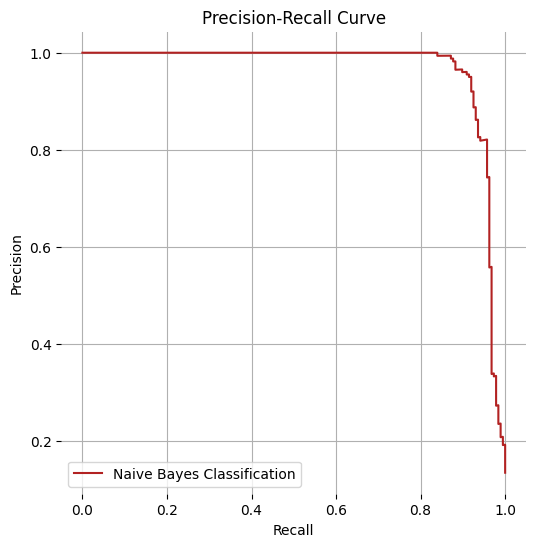

In [630]:
# Αν y_test είναι Series με labels "spam"/"ham", το μετατρέπουμε σε binary (π.χ. 1=spam, 0=ham)
y_test_bin = (y_test == 'spam').astype(int)

# Προβλέψεις πιθανοτήτων για την κλάση "spam"
y_pred_proba = classifier.predict_proba(X_test)[:, 1]

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test_bin, y_pred_proba)


fig, ax = matplotlib.pyplot.subplots(figsize=(6, 6))
ax.plot(recall, precision, label='Naive Bayes Classification', color='firebrick')
ax.set_title('Precision-Recall Curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend()
matplotlib.pyplot.grid(True)
matplotlib.pyplot.box(False)
matplotlib.pyplot.show()

Ο άξονας Χ (Recall): Πόσα από τα πραγματικά spam εντοπίστηκαν.

Ο άξονας Υ (Precision): Από τα όσα το μοντέλο είπε ότι είναι spam, πόσα ήταν σωστά.

Ιδανικά θες ψηλά Precision και ψηλό Recall, αλλά υπάρχει συνήθως trade-off.

Το μεγαλύτερο μέρος της γραμμής είναι πολύ ψηλά (Precision ≈ 1.0).

Αυτό σημαίνει ότι το μοντέλο σου είναι πολύ σίγουρο όταν προβλέπει κάτι ως spam — σχεδόν πάντα έχει δίκιο.

Όμως, προς το τέλος, η Precision πέφτει απότομα καθώς αυξάνεται το Recall:

Το μοντέλο αρχίζει να εντοπίζει περισσότερα spam, αλλά αρχίζει να κάνει περισσότερα λάθη (False Positives).

### Παρατήρηση

Τα δεδομένα που χρησιμοποιεί ο αλγόριθμος έχουν υποστεί μόνο βασικό καθαρισμό, όπως αφαίρεση URLs, εικονιδίων (icons), emojis και μετατροπή σε πεζά (lowercase). Δεν έχει εφαρμοστεί περαιτέρω επεξεργασία.

Σε περίπτωση που εφαρμόσουμε μια συνάρτηση που περιλαμβάνει αφαίρεση stopwords και stemming, παρατηρείται σημαντική πτώση στην απόδοση του μοντέλου, τόσο ως προς την ακρίβεια (Accuracy), όσο και ως προς τις μετρικές Precision, Recall και F1 Score.

Αυτό θεωρείται αναμενόμενο, καθώς ο στόχος μας είναι η ταξινόμηση των κανονικών μηνυμάτων (ham) και των ανεπιθύμητων (spam). Η εφαρμογή αφαίρεσης stopwords οδηγεί στην απώλεια λέξεων-κλειδιών που συχνά χαρακτηρίζουν τα spam, όπως "free", "win", "now", κ.ά. Επιπλέον, με την εφαρμογή stemming, αλλοιώνεται η μορφολογική δομή των λέξεων που απομένουν, γεγονός που μπορεί να μειώσει την ικανότητα του μοντέλου να αναγνωρίσει μοτίβα. Συνεπώς, η υπερβολική επεξεργασία ενδέχεται να αφαιρέσει κρίσιμη σημασιολογική πληροφορία, επηρεάζοντας αρνητικά την τελική ταξινόμηση.

## Word2Vec + Classifier 

Το Word2Vec + Classifier είναι ένας συνδυασμός τεχνικών επεξεργασίας φυσικής γλώσσας και μηχανικής μάθησης, όπου τα κείμενα μετατρέπονται πρώτα σε αριθμητικά διανύσματα μέσω του Word2Vec και στη συνέχεια ταξινομούνται με τη βοήθεια ενός αλγορίθμου ταξινόμησης, όπως η Logistic Regression ή ο Naive Bayes. Το Word2Vec μαθαίνει να αναπαριστά τις λέξεις σε ένα νοηματικό χώρο, διατηρώντας σχέσεις ομοιότητας, ενώ ο ταξινομητής χρησιμοποιεί αυτές τις αναπαραστάσεις για να προβλέψει την κατηγορία κάθε μηνύματος (π.χ. ham ή spam).



In [631]:
#Εκπαίδευση Word2Vec
w2v_model = gensim.models.Word2Vec(cleanedAllMessage,
                                   vector_size=100,
                                   window=5,
                                   min_count=2)

Εδώ ο αλγόριθμός κάνει κάθε λέξη ένα διάνυσμα 100 διαστάσεων και αναλόγως το πόσο κοντά εμφανίζεται κάθε λέξη έχει και κοντινά διανίσματα.

cleanedAllMessage: Η λιστα απο τα email που έχουν γίνει tokenization

vector_size=100: Κάθε λέξη θα εκπροσωπείται με διάνυσμα 100 διαστάσεων

window=5: Το Word2Vec "βλέπει" 5 λέξεις πριν και 5 μετά για να μάθει τη σχέση ανάμεσα σε λέξεις

min_count=2: Αγνοεί λέξεις που εμφανίζονται λιγότερο από 2 φορές στο σύνολο δεδομένων (θεωρούνται ασήμαντες)

In [632]:
def vectorize(sentence):
    valid_tokens = [word for word in sentence if word in w2v_model.wv.key_to_index]
    if not valid_tokens:
        return [0]*w2v_model.vector_size
    return w2v_model.wv[valid_tokens].mean(axis=0)

Παίρνει όλα τα διανύσματα των έγκυρων λέξεων και επιστρέφει τον μέσο όρο. 

Γιατί το Word2Vec δουλεύει σε επίπεδο λέξεων, αλλά ο ταξινομητής χρειάζεται ένα διάνυσμα για όλο το μήνυμα.

In [633]:
vectorW2V = cleanedAllMessage.apply(vectorize) 

Άρα παίρνουμε τον μέσο όρο των λέξεων που περιέχει το κάθε μήνυμα → ώστε να φτιάξουμε ένα αντιπροσωπευτικό "προφίλ".

In [634]:
X = vectorW2V.tolist()
y = df['Category']

Μετατρέπει τη Pandas Series που περιέχει τα διανύσματα μηνυμάτων (Word2Vec) σε λίστα Python.

Το X είναι λίστα διανυσμάτων

Παίρνει τη στήλη Category από το αρχικό df

In [635]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 42, stratify=y
)

X_train	Δεδομένα για εκπαίδευση (διανύσματα) -> Είναι τα δεδομένα που θα "δει" το μοντέλο στην εκπαίδευση. Κάθε στοιχείο είναι ένα διάνυσμα που αναπαριστά ένα μήνυμα (από Word2Vec).

X_test	Δεδομένα για έλεγχο -> Είναι τα δεδομένα που δεν έχει ξαναδεί το μοντέλο. Χρησιμοποιούνται για να δοκιμάσουμε την ακρίβειά του.

y_train	Σωστές κατηγορίες για τα X_train -> Περιέχει τις σωστές απαντήσεις για κάθε μήνυμα του X_train. Είναι ham ή spam.

y_test	Σωστές κατηγορίες για τα X_test -> Οι σωστές απαντήσεις για τα μηνύματα του X_test. Τις χρησιμοποιούμε για σύγκριση με τις προβλέψεις του μοντέλου.

In [636]:
# 7. Εκπαίδευση classifier (Logistic Regression)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Εδώ θα χρισημοποιήσουμε τον LogisticRegression αντι του MultinomialNB(), γιατί τα δεδομένα μας είναι διανύσματα. 

Καταμέτρηση λέξεων	MultinomialNB()

Διανύσματα λέξεων (Word2Vec, Embeddings)	LogisticRegression, SVC, RandomForest, KNN, κ.ά.

In [637]:
# Evaluate the model
y_pred = clf.predict(X_test)

predict() ζητάει από το μοντέλο να προβλέψει αν κάθε μήνυμα είναι ham ή spam στα διανύσματα που έχει το X_test

In [638]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy  : {accuracy:.4f}")

Accuracy  : 0.9691


Το ποσοστό των σωστών προβλέψεων του μοντέλου είναι 96%

Συγκρίνει τις πραγματικές ετικέτες (y_test) με τις προβλεπόμενες (y_pred), και μετρά πόσες ήταν σωστές.

In [639]:
precision = precision_score(y_test, y_pred, pos_label='spam')
print(f"Precision : {precision:.4f}")

Precision : 0.9286


Από όλα τα μηνύματα που προβλέψαμε ως spam το 93% είναι σωστό

In [640]:
recall = recall_score(y_test, y_pred, pos_label='spam')
print(f"Recall    : {recall:.4f}")

Recall    : 0.8342


Από όλα τα πραγματικά spam μηνύματα στο test set, κατάφερε να βρει το μοντέλο μας 82%

In [641]:
f1 = f1_score(y_test, y_pred, pos_label='spam')
print(f"F1 Score  : {f1:.4f}")

F1 Score  : 0.8789


Το F1 Score είναι ένας συνδυασμός του Precision και του Recall.
Συγκεκριμένα, είναι ο αρμονικός μέσος όρος των δύο:

F1 = 2* (precision * recall / precision + recall)

Ο ταξινομητής Word2Vec + Logistic Regression πέτυχε F1 Score 87.82%, γεγονός που δείχνει πολύ καλή γενική απόδοση.

Το μοντέλο μας εντοπίζει αποτελεσματικά τα spam emails, ισορροπώντας την ακρίβεια με την ικανότητα εντοπισμού.

In [642]:
# Προσθήκη αποτελεσματων για το Word2Vec
accuracy_scores["Word2Vec"] = accuracy
precision_scores["Word2Vec"] = precision
recall_scores["Word2Vec"] = recall
f1_scores["Word2Vec"] = f1

<Axes: >

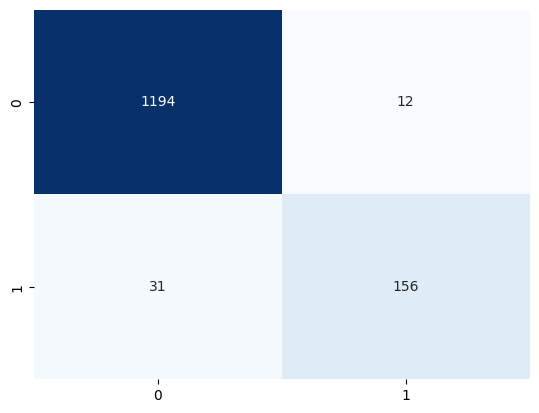

In [643]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

Πάνω αριστερά: σωστά ham

Κάτω δεξιά: σωστά spam

Πάνω δεξιά: λάθος spam σε ham ➜ false positives

Κάτω αριστερά: λάθος ham σε spam ➜ false negatives

# RNN

In [644]:
# Χρησιμοποιούμε τα cleaned μηνύματα
texts = [' '.join(tokens) for tokens in cleanedAllMessage]
labels = df['Category'].values

In [645]:
# Μετατροπή κατηγορίας σε 0/1
le = LabelEncoder()
y = le.fit_transform(labels)

Μετατρέπουμε τις κατηγορικές ετικέτες (labels), π.χ. 'ham', 'spam', σε αριθμούς (0 και 1) 
ώστε να μπορούν να χρησιμοποιηθούν από τα μοντέλα μηχανικής μάθησης.

Παίρνει το array le με τις κατηγορίες (π.χ.): le = ['ham', 'ham', 'spam', 'ham', 'spam']

Και

y = [0, 0, 1, 0, 1]

In [646]:
# Tokenization και sequences
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')

Εδώ δημιουργούμε ένα Tokenizer αντικείμενο από το Keras, το οποίο:

Με παραμέτρους

num_words=5000 -> Κρατάει τις 5.000 πιο συχνές λέξεις από το σύνολο των email

oov_token='<OOV>' -> Δημιουργούμε ειδικό token για λέξεις εκτός λεξιλογίου (Out-Of-Vocabulary)

Αυτό σημαίνει ότι όλες οι σπάνιες λέξεις (εκτός των 5.000 πιο συχνών) θα αντικατασταθούν με τον αριθμό που αντιστοιχεί στο <OOV> token.

In [647]:
# Tokenization και sequences
tokenizer.fit_on_texts(texts)

"Εκπαιδεύουμε" τον tokenizer πάνω στα δεδομένα κειμένου:

Μετράει πόσες φορές εμφανίζεται κάθε λέξη

Αναθέτει σε κάθε λέξη έναν μοναδικό ακέραιο αριθμό ID

πχ

tokenizer.word_index:
{
  'free': 1,
  'win': 2,
  'prize': 3,
  'spam': 4,
  ...
}

In [648]:
# Tokenization
sequences = tokenizer.texts_to_sequences(texts)

Μετατρέπει κάθε email σε λίστα αριθμών, όπου κάθε αριθμός είναι το ID της λέξης.

πχ
texts = ["win free", "free prize"]
sequences = [[2, 1], [1, 3]]

In [649]:
# Padding (όλες οι ακολουθίες στο ίδιο μήκος)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

Το pad_sequences το χρησιμοποιούμε για να κανονικοποιήσουμε το μήκος όλων των ακολουθιών λέξεων (token IDs), ώστε να έχουν ίδιο μήκος — κάτι που απαιτείται από το RNNs και άλλα νευρωνικά δίκτυα.

Τι κάνει ακριβός

κάθε email θα μετατραπεί σε ακολουθία μήκους 100 αριθμών

αν είναι μικρότερο → θα προστεθούν μηδενικά μπροστά

αν είναι μεγαλύτερο → θα κοπεί από την αρχή ή το τέλος

Βάζουμε μήκος 100 maxlen γιατί θεωρουμε ότι όλα τα email δεν θα ξεπερνάνε το μήκος λέξεων τον 120.

πχ
Απο
sequences = [
    [10, 4, 2],
    [3, 8],
    [1]
]
Σε
X =
[
 [0, 0, 10, 4, 2],
 [0, 0, 0, 3, 8],
 [0, 0, 0, 0, 1]
]

Γιατί sequence

Η χρήση sequences σε προβλήματα όπως η ταξινόμηση email (π.χ. spam/ham) δεν είναι τυχαία — είναι κρίσιμο βήμα για να μετατρέψουμε κείμενο σε μορφή που καταλαβαίνουν τα νευρωνικά δίκτυα.

Τα μοντέλα όπως τα RNN, LSTM, CNN, BERT:

ΔΕΝ μπορούν να δουλέψουν απευθείας με συμβολοσειρές (π.χ. 'free prize')

Χρειάζονται αριθμητική αναπαράσταση (π.χ. [1, 42])

Άρα, το sequence είναι η ψηφιακή μετάφραση του κειμένου.


In [650]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Σε αυτό το βήμα κάνουμε τον διαχωρισμό των δεδομένων σε εκπαίδευση και δοκιμή (train/test split), κάτι που είναι βασικό βήμα σε κάθε μοντέλο μηχανικής μάθησης ή deep learning.

X ->	Τα δεδομένα εισόδου (π.χ. tokenized και padded emails)

y ->	Οι αντίστοιχες ετικέτες (π.χ. spam, ham)

test_size=0.25 ->	Κρατά το 25% των δεδομένων για δοκιμή και το υπόλοιπο 75% για εκπαίδευση

stratify=y ->	Διατηρεί την ίδια αναλογία spam/ham και στα δύο σύνολα (train και test)

random_state=42 ->	Εξασφαλίζει ότι ο διαχωρισμός θα είναι επαναλήψιμος (για ίδιους αριθμούς κάθε φορά)

In [651]:
model = tf.keras.Sequential([
    Input(shape=(100,)),  # <= Καθαρή δήλωση εισόδου
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.SimpleRNN(32, activation='tanh'),  # Κλασικό RNN,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Το μοντέλο μας εδώ είναι ένα νευρωνικό δίκτυο βασισμένο σε RNN (Recurrent Neural Network) για δυαδική ταξινόμηση, όπως η διάκριση email σε spam ή ham.

Δηλώνουμε ότι κάθε δείγμα εισόδου είναι ακολουθία 100 tokens Input(shape=(100,)).

Μετατρέπουμε κάθε token (π.χ. 52, 731) σε διάνυσμα 64 διαστάσεων Embedding(input_dim=5000, output_dim=64) -> Τελικό output σχήμα: (100, 64) → δηλαδή, 100 λέξεις με 64 διαστάσεις η καθεμία..

SimpleRNN(64, activation='tanh') εδώ είναι το RNN layer. Παίρνει ως είσοδο τη σειρά των embeddings και προσπαθεί να "θυμηθεί" patterns στην ακολουθία.Επισης Διατηρεί κατάσταση (state) μέσα στην ακολουθία, π.χ. "αν είδα τη λέξη 'win' και μετά 'money'".Εδώ χρησιμοποιούμε το tanh γιατί βοηθά να διατηρηθεί ισορροπία θετικών/αρνητικών τιμών και είναι κατάλληλο για μνήμη.

Για να αποφευχθεί overfitting, ρίχνουμε τυχαία το 30% των συνδέσεων κατά την εκπαίδευση. Dropout(0.3)

Dense(1, activation='sigmoid') -> Τελική έξοδος: ένα νούμερο μεταξύ 0 και 1. 
Με sigmoid ενεργοποίηση, ερμηνεύεται ως:
κοντά στο 0 → ham
κοντά στο 1 → spam

In [652]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)             │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,137 (1.23 MB)

 Trainable params: 323,137 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

Ενα απο τα πιο σημαντικά βήματα συνοψήζη και προετοιμάζει το μοντέλο μας πρίν την εκπαίδευση.

model.compile(...) - > Λέει στον tensorFlow πως να εκπαιδευση το μοντέλο μας:

loss='binary_crossentropy' -> Το χρησιμοποιόυμε για δυαδική ταξινόμηση (0 = ham, 1 = spam).

Υπολογίζει πόσο κακή είναι η πρόβλεψη σε σχέση με την πραγματική ετικέτα.

Βασίζεται στην πιθανότητα που δίνει η sigmoid του μοντέλου. Παράδειγμα: Αν το μοντέλο λέει ότι είναι spam με πιθανότητα 0.9 αλλά είναι ham (0), η τιμωρία (loss) θα είναι μεγάλη.

optimizer='adam':

Είναι ο βελτιστοποιητής που προσαρμόζει τα βάρη του μοντέλου κατά την εκπαίδευση.

adam = Adaptive Moment Estimation: πολύ καλός και γρήγορος για κείμενο.

metrics=['accuracy']:

Ζητάμε να παρακολουθεί την ακρίβεια (accuracy) κατά την εκπαίδευση.Δηλαδή: Πόσες προβλέψεις είναι σωστές / σύνολο δειγμάτων


Embedding ->	Μαθαίνει να μετατρέπει κάθε λέξη σε διάνυσμα νοήματος

SimpleRNN ->	Μαθαίνει να μαθαίνει τη "σειρά" των λέξεων και κρατάει μνήμη

Dense -> 	Μαθαίνει να βγάζει την τελική πρόβλεψη (spam ή ham)

In [653]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.8936 - loss: 0.3208 - val_accuracy: 0.9440 - val_loss: 0.1933
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9349 - loss: 0.2314 - val_accuracy: 0.9605 - val_loss: 0.1344
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9716 - loss: 0.1228 - val_accuracy: 0.9677 - val_loss: 0.1180
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9616 - loss: 0.1427 - val_accuracy: 0.9670 - val_loss: 0.1210
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9720 - loss: 0.1125 - val_accuracy: 0.9727 - val_loss: 0.1146


Εδώ εκπαιδέυουμε το μοντέλο μας 

X_train ->	Τα input δεδομένα (π.χ. tokenized + padded emails)

y_train ->	Οι κατηγορίες τους (π.χ. 0 = ham, 1 = spam)

epochs=5 ->	Πόσες φορές θα "διαβάσει" το σύνολο των δεδομένων το μοντέλο

batch_size=32	-> Πόσα δείγματα θα εκπαιδεύονται κάθε φορά πριν ενημερώσει τα βάρη

validation_data=(X_test, y_test)	Δίνει στο μοντέλο ξεχωριστά δεδομένα για έλεγχο της απόδοσης σε κάθε epoch




### περιγραφή αποτελεσμάτων RNN

Το μοντέλο μας RNN εκπαιδεύτηκε για Epoch με στόχο τη δυαδική ταξινόμηση email (π.χ. spam ή ham). Από την αρχή της εκπαίδευσης, παρουσίασε υψηλή ακρίβεια, με το train accuracy να ξεκινά στο 88.5% και να φτάνει το 97.2% στο τέλος. Το validation accuracy διατηρήθηκε εξίσου υψηλό καθ' όλη τη διάρκεια, με τιμές από 96.0% έως 97.5%.

Το loss (σφάλμα) μειώθηκε σημαντικά στο training set, δείχνοντας ότι το μοντέλο μαθαίνει καλά τα δεδομένα του. Αντίστοιχα, και το validation loss παρέμεινε σε χαμηλά επίπεδα (0.11–0.13), γεγονός που δείχνει ότι το μοντέλο γενικεύει καλά και δεν παρουσιάζει μεγάλες διακυμάνσεις.

Συμπέρασμα, το RNN μοντέλο μας παρουσιάζει πολύ καλή απόδοση και τα αποτελέσματα είναι πολύ ικανοποιητικά, με σταθερή πορεία μάθησης, υψηλή ακρίβεια και χωρίς εμφανή σημάδια υπερεκπαίδευσης (overfitting).

In [654]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=le.classes_))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      1206
        spam       0.97      0.82      0.89       187

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



In [655]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy  : {accuracy:.4f}")

Accuracy  : 0.9727


In [656]:
precision = precision_score(y_test, y_pred, pos_label=1)
print(f"Precision : {precision:.4f}")

Precision : 0.9745


In [657]:
recall = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall    : {recall:.4f}")

Recall    : 0.8182


In [658]:
f1 = f1_score(y_test, y_pred, pos_label=1)
print(f"F1 Score  : {f1:.4f}")

F1 Score  : 0.8895


In [659]:
# Προσθήκη αποτελεσματων για το RNN
accuracy_scores["RNN"] = accuracy
precision_scores["RNN"] = precision
recall_scores["RNN"] = recall
f1_scores["RNN"] = f1

<Axes: >

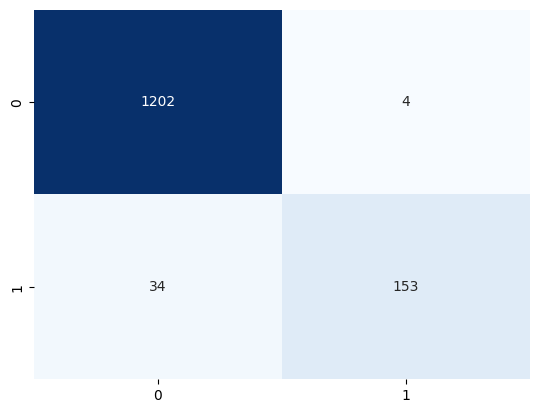

In [660]:
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Συνολικές Μετρίσεις

In [661]:
# Plot για κάθε μετρική
def plot_metric(metric_dict, title, color):
    models = list(metric_dict.keys())
    scores = list(metric_dict.values())

    matplotlib.pyplot.figure(figsize=(8, 5))
    bars = matplotlib.pyplot.bar(models, scores, color=color, edgecolor='black', width=0.6)

    # Εμφάνιση τιμής πάνω από κάθε μπάρα
    for bar in bars:
        yval = bar.get_height()
        matplotlib.pyplot.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}",
                 ha='center', va='bottom', fontsize=12, weight='bold')

    matplotlib.pyplot.title(title, fontsize=14, weight='bold')
    matplotlib.pyplot.ylim(0.0, 1.05)
    matplotlib.pyplot.ylabel("Score", fontsize=12)
    matplotlib.pyplot.xticks(fontsize=11)
    matplotlib.pyplot.yticks(fontsize=11)
    matplotlib.pyplot.grid(True, linestyle="--", alpha=0.3)
    matplotlib.pyplot.box(False)
    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()

## Accuracy

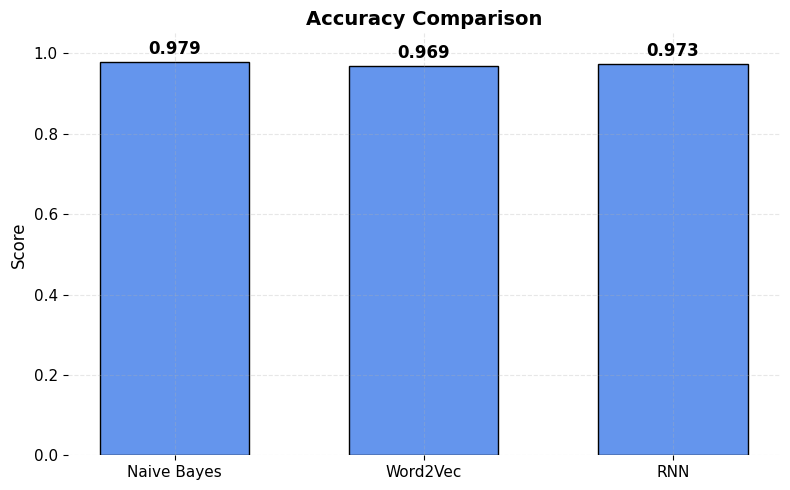

In [666]:
plot_metric(accuracy_scores, "Accuracy Comparison", "cornflowerblue")

### Συμπέρασμα για τη συνολική ακρίβεια (Accuracy)

Η σύγκριση toy accuracy ανάμεσα στα τρία μοντέλα — Naive Bayes, Word2Vec με Logistic Regression, και RNN — αποκαλύπτει ότι όλα τους έχουν εξαιρετικές επιδόσεις στην κατηγοριοποίηση των email σε spam και ham. Το μοντέλο Naive Bayes ξεχωρίζει με την υψηλότερη ακριβεια, φτάνοντας το 0.979, ακολουθούμενο από το RNN με 0.973, ενώ το Word2Vec + Logistic Regression αγγίζει το 0.969. Οι διαφορές τους είναι μικρές, υποδεικνύοντας ότι όλα τα μοντέλα είναι αποτελεσματικά για το συγκεκριμένο προβλημα. Παρ' όλα αυτά, το Naive Bayes έχει μια ελαφριά υπεροχή στην ακρίβεια, πιθανώς λόγω της απλότητας των δεδομένων και της καταλληλότητας της υπόθεσης ανεξαρτεισίας σε αυτή την περίπτωση. Το RNN παραμένει ισχυρό, ειδικά αν σκοπεύουμε να επεκταθούμε σε πιο σύνθετα ή μεγαλύτερα σύνολα δεδομένων.

## Precision

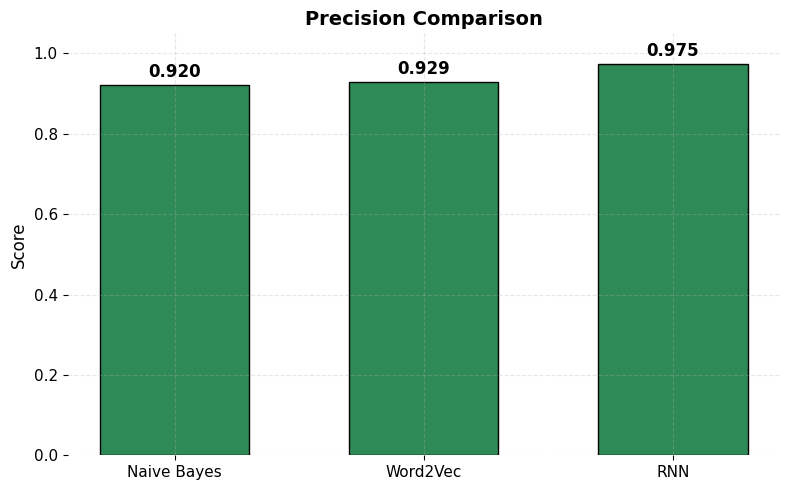

In [663]:
plot_metric(precision_scores, "Precision Comparison", "seagreen")

### Συμπέρασμα για την ακρίβεια θετικών προβλέψεων (Precision)

Η σύγκριση των μοντέλων όσον αφορά την Precision — δηλαδή την ικανότητά τους να εντοπίζουν σωστά τα spam emails χωρίς να κάνουν πολλά λaθη (false positives) — δείχνει ότι το RNN μοντέλο ξεχωρίζει. Το RNN πέτυχε precision 0.975, που σημαίνει ότι όταν χαρακτηρίζει ένα email ως spam, είναι σχεδόν πάντα σωστό.

Ακολουθεί το μοντέλο Word2Vec + Logistic Regression με 0.929, που είναι επίσης πολύ υψηλή τιμή, ενώ το Naive Bayes έχει την χαμηλότερη τιμη με 0.920. Αν και οι αριθμοί φαίνονται κοντά, στην πράξη αυτό μπορεί να σημαίνει λιγότερες λανθασμένες ειδοποιήσεις για τον χρήστη (false alarms).

Συνολικά, το RNN αποδεικνύει ότι έχει την καλύτερη ακρίβεια στις θετικές προβλεψεις, κάνοντάς το πιο αξιοπίστο στην αποφυγή "ψευδών spam" — ένα κρίσιμο χαρακτηριστικό για τις εφαρμογές φίλτρων email.

## Recall

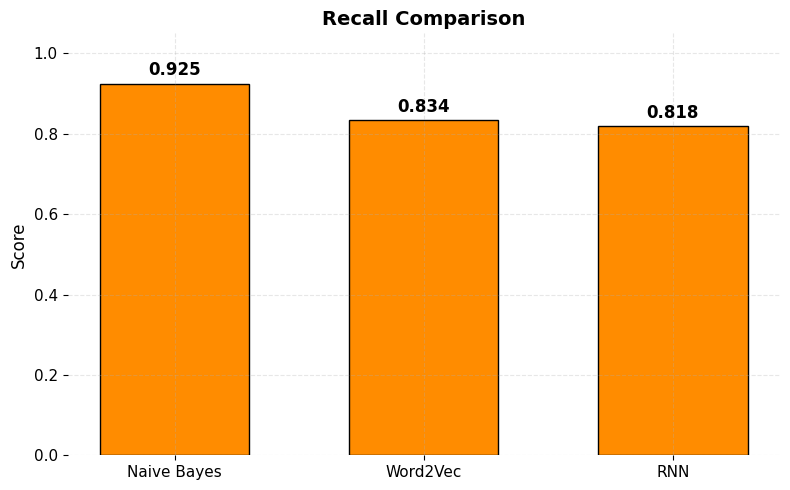

In [664]:
plot_metric(recall_scores, "Recall Comparison", "darkorange")

### Συμπέρασμα για το Recall

Η σύγκριση των μοντέλων όσον αφορά το Recall — δηλαδή την ικανότητά τους να εντοπίζουν όλα τα πραγματικά θετικά περιστατικά (spam emails) — αποκαλύπτει ότι το μοντέλο Naive Bayes έχει την καλήτερη απόδοση με τιμή 0.925. Αυτό σημαίνει ότι το μοντέλο μπορεί να αναγνωρίσει το 92.5% των πραγματικών spam μηνυμάτων, κάτι που είναι εξαιρετικά σημαντικό για ένα φίλτρο ανεπιθύμητης αλληλογραφίας.

Ακολουθεί το μοντέλο Word2Vec + Logistic Regression με recall 0.834, και στη συνέχεια το RNN με recall 0.818. Οι χαμηλότερες τιμές για Word2Vec και RNN δείχνουν ότι χάνουν περισσότερα πραγματικά spam μηνύματα (false negatives), κάτι που σε πραγματικές συνθήκες θα μπορούσε να οδηγήσει σε ανεπιθύμητα emails που περνούν απαρατήρητα.

Συμπερασματικά, αν η προτεραιότητα είναι να μην χάνεται κανένα spam email, τότε το Naive Bayes είναι η καλύτερη επιλογή. Ωστόσο, θα πρέπει να εξεταστεί και η precision, ώστε να βρεθεί η σωστή ισορροπία μεταξύ ευαισθησίας και ακρίβειας.

## F1 Score

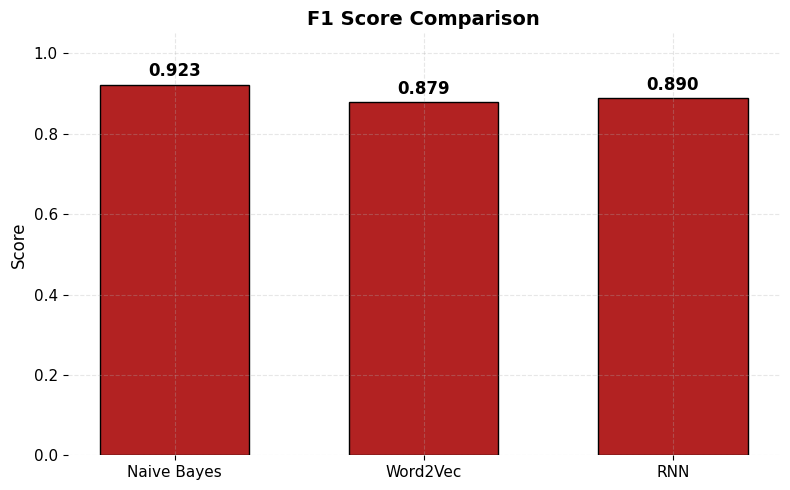

In [665]:
plot_metric(f1_scores, "F1 Score Comparison", "firebrick")

### Συμπέρασμα για το F1-Score

Η σύγκριση των μοντέλων με βάση το F1-Score είναι μια μέτρηση που βρίσκει την ισορροπία ανάμεσα στην ακρίβεια (precision) και την ευαισθησία (recall). Στην ανάλυσή μας, βλέπουμε ότι το Naive Bayes πετυχαίνει τον καλύτερο συνδυασμό με F1-Score 0.923. Αυτό το αποτέλεσμα δεν μας ξαφνιάζει, καθώς το Naive Bayes είχε ήδη δείξει υψηλή ακρίβεια (0.920) και εξαιρετική ευαισθησία (0.925), πράγμα που σημαίνει ότι είναι και ακριβές και ευαίσθητο στην ανίχνευση των spam.

Από την άλλη, το RNN δείχνει υψηλή ακρίβεια (0.975) — που σημαίνει ότι είναι εξαιρετικό στο να εντοπίζει σωστά τις περιπτώσεις spam χωρίς να κάνει πολλά λάθη — αλλά έχει πιο περιορισμένη ευαισθησία (0.818), που σημαίνει ότι "χάνει" κάποια spam μηνύματα. Αν και αυτό το trade-off οδηγεί σε ελαφρώς χαμηλότερο F1 (0.890), παραμένει μια πολύ ισχυρή επιλογή, ειδικά όταν είναι κρίσιμο να μην κατηγοριοποιούνται λανθασμένα τα κανονικά μηνύματα ως spam.

Το μοντέλο Word2Vec + Logistic Regression έχει ισορροπημένες αλλά ελαφρώς χαμηλότερες επιδόσεις σε όλα τα metrics (ακρίβεια: 0.929, ευαισθησία: 0.834, F1: 0.879), και έτσι κατατάσσεται τρίτο σε συνολική απόδοση.

# Τελική εκτίμηση

Αν ο στόχος είναι να μην χάσουμε κανένα spam, τότε το Naive Bayes είναι η καλύτερη επιλογή, καθώς έχει πολύ υψηλό recall.

Αν, όμως, προτεραιότητα είναι να μειωθούν οι ψευδείς ειδοποιήσεις (false positives), τότε το RNN προσφέρει καλύτερη precision, αν και θυσιάζει την recall.

Το Word2Vec είναι σταθερό και ισορροπημένο, αλλά λίγο πιο αδύναμο σε σύγκριση με τα άλλα δύο.

Συνολικά, το Naive Bayes προσφέρει την πιο ισορροπημένη απόδοση, ειδικά αν το αξιολογήσουμε με βάση το F1-score, το οποίο δίνει ίση σημασία στην ακριβή και πλήρη ανίχνευση των spam.